## Information from kaggle

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### We will perform few preprocessing steps on the data  such as 
look for duplicate values.

update missing data points with respective mean, median and mode if required.(as our data is not missing any values we dont need this)

converting categorical variable into one hot encoding if required (as our data is numberical we dont need this)

In [4]:
data.shape

(284807, 31)

### Looking for duplicate values in dataset
We could have removed the duplicate data but then we will loose a lot of fraud points as well. so I have decided to keep the duplicate points. (below is the code just to show that we can run to remove the duplicate points)

In [5]:
duplicate = data[data.duplicated()]

### Printing the number of duplicate datapoints

In [6]:
duplicate.shape

(1081, 31)

In [7]:
fraud = duplicate[duplicate['Class'] == 1]
valid = duplicate[duplicate['Class'] == 0]
outlierFraction = len(fraud)/float(len(valid))
print(outlierFraction)
print(' Duplicate Fraud Cases: {}'.format(len(duplicate[duplicate['Class'] == 1])))
print(' Duplicate Valid Transactions: {}'.format(len(duplicate[duplicate['Class'] == 0])))

0.017890772128060263
 Duplicate Fraud Cases: 19
 Duplicate Valid Transactions: 1062


### Checking for null values

In [8]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]
outlierFraction = len(fraud)/float(len(valid))
print(outlierFraction)
print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


### As seen above, there are only 0.17% cases for fraudulent transaction in the whole dataset. the data is highly unbalanced

In [10]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

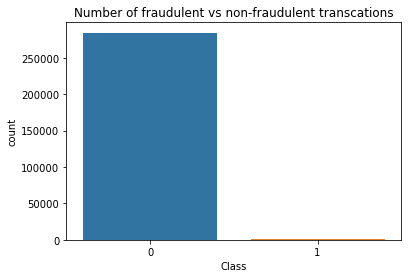

In [11]:
sns.countplot(x='Class', data=data)
plt.title('Number of fraudulent vs non-fraudulent transcations')
plt.show()

Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

In our dataset, Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset which we can featurize using robust scalar method instead of standard scalar.
We are using Robust scalar because it is not prone to outliers

First we will take a look at how the datapoints inside the Amount feature looks like.

In [12]:
print('Values in feature amount => \n', data['Amount'][0:10])

Values in feature amount => 
 0    149.62
1      2.69
2    378.66
3    123.50
4     69.99
5      3.67
6      4.99
7     40.80
8     93.20
9      3.68
Name: Amount, dtype: float64


We'll now apply a normal scalar transformation on the Amount variable because the datapoints in the feature amount aren't scaled in comparison to the other features in the dataset, and the values appear to be in dollar currency, according to the data description. 

Log Transformation: The log transformation is employed as a scaling method when the variables span many orders of magnitude. 

Standardization: With standardisation as a scaling approach, the values are centred all over the mean with something close to a unit standard deviation.
This means that the attribute's mean drops to zero, and the resultant distribution has a one-unit standard deviation. 

Normalization: Normalization (Min-Max Scaling) is a rescaling technique in which the values are pushed and rescaled to lie between 0 and 1. 

We'll compare which scaling approach best fits our dataset, and we'll use a box-plot to do so. 

In [13]:
# Scale amount by log
data['amount_log'] = np.log(data.Amount + 0.01)

#Scale amount by Standardization
from sklearn.preprocessing import StandardScaler 
ss = StandardScaler()
data['amount_scaled'] = ss.fit_transform(data['Amount'].values.reshape(-1,1))

#Scale amount by Normalization
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler()
data['amount_minmax'] = norm.fit_transform(data['Amount'].values.reshape(-1,1))

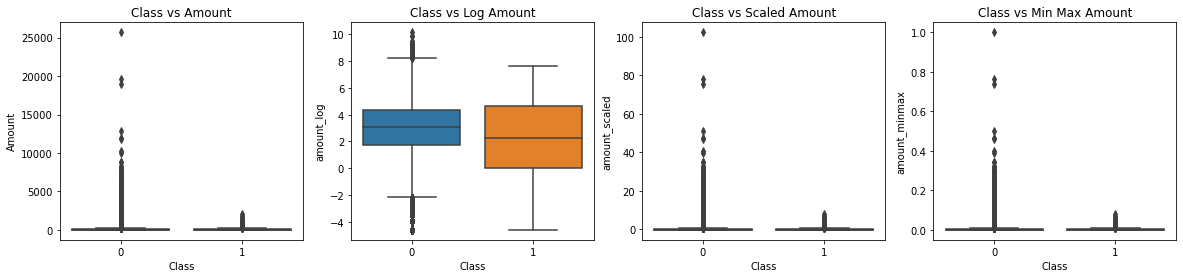

In [14]:
fig,axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (20,4))

sns.boxplot(x ="Class",y="Amount",data=data, ax = axs[0])
axs[0].set_title("Class vs Amount")

sns.boxplot(x ="Class",y="amount_log",data=data, ax = axs[1])
axs[1].set_title("Class vs Log Amount")

sns.boxplot(x ="Class",y="amount_scaled",data=data, ax = axs[2])
axs[2].set_title("Class vs Scaled Amount")

sns.boxplot(x ="Class",y="amount_minmax",data=data, ax = axs[3])
axs[3].set_title("Class vs Min Max Amount")

plt.show()

Log Scaling indicated the lowest error.
The values for 0 and 1 class are significantly different.
As a result, we'd take Log Scaling a step further.

Now we are done with the scalar transformation so we will remove the Amount feature from our dataset and add the scaled_amount feature to our dataset.

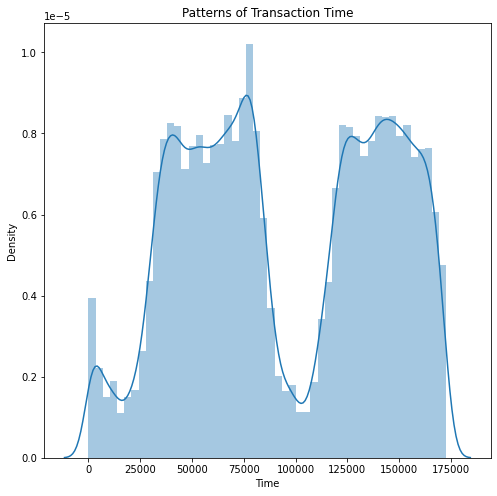

In [15]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(8,8))
plt.title('Patterns of Transaction Time')
sns.distplot(data['Time'])
plt.show()

There appear to be two events in the plot.

This data collection spans two days.

The two peaks refer to the two times of the day when the most payments are recorded (and decline shows the night time where there are no transactions). 

Now we'll plot Time-Distribution of fraudulent and non-fraudulent transactions to see if any trends emerge. 

Now we’re going to plot Time-Distribution graphs of Fraud and Non-Fraud Transactions and will observe if we find any patterns.

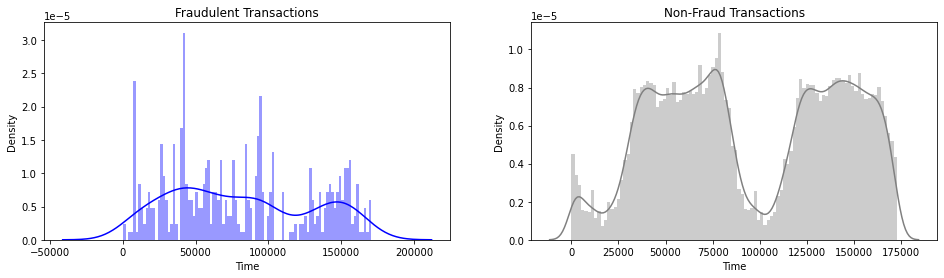

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))

sns.distplot(data[(data['Class'] == 1)]['Time'],bins=100,color='blue', ax=axs[0])
axs[0].set_title("Fraudulent Transactions")

sns.distplot(data[(data['Class'] == 0)]['Time'], bins=100,color='grey', ax=axs[1])
axs[1].set_title("Non-Fraud Transactions")

plt.show()

There is no such information that can be derived from the Time Feature.

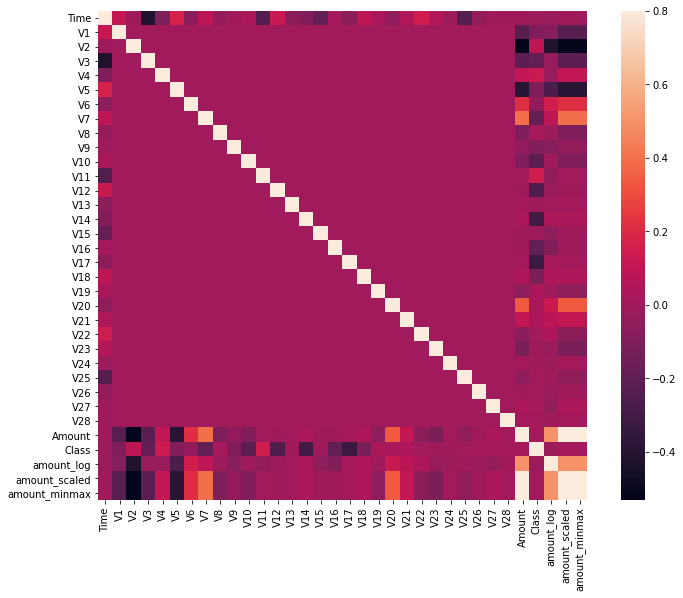

In [17]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [18]:
data = data.drop(['Time','Amount','amount_minmax','amount_scaled'],axis=1)

### As discussed in PyData LA 2018 Data event and the research paper for Credit Card Fraud Detection the data should be undersampled first and then analysed due to the highly imbalance nature of data.Whichever analysis or machine learning algorithm we perform the data is going to be only predicting the majority of the classes. So first we will under sample the data and then perform our further analysis.


In [19]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [20]:
X = data.drop(['Class'], axis=1)
y = data['Class']

In [21]:
from sklearn.model_selection import train_test_split
# Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

### Checking the data for Normal Distribution

In [22]:
cols = X_train.columns
cols

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'amount_log'],
      dtype='object')

I need to check the distribution of each feature. I wanted to check if the data is normally distributed or its skewed. if they are skewed then we will perform some transformation on it so that we can normally distribute them.

The below Data Visualization takes time to run but in a single query (python code) we are able to view all the distribution of variables/features. In real world case, we make a machine learning model to be robust and according to the low latency requirements.


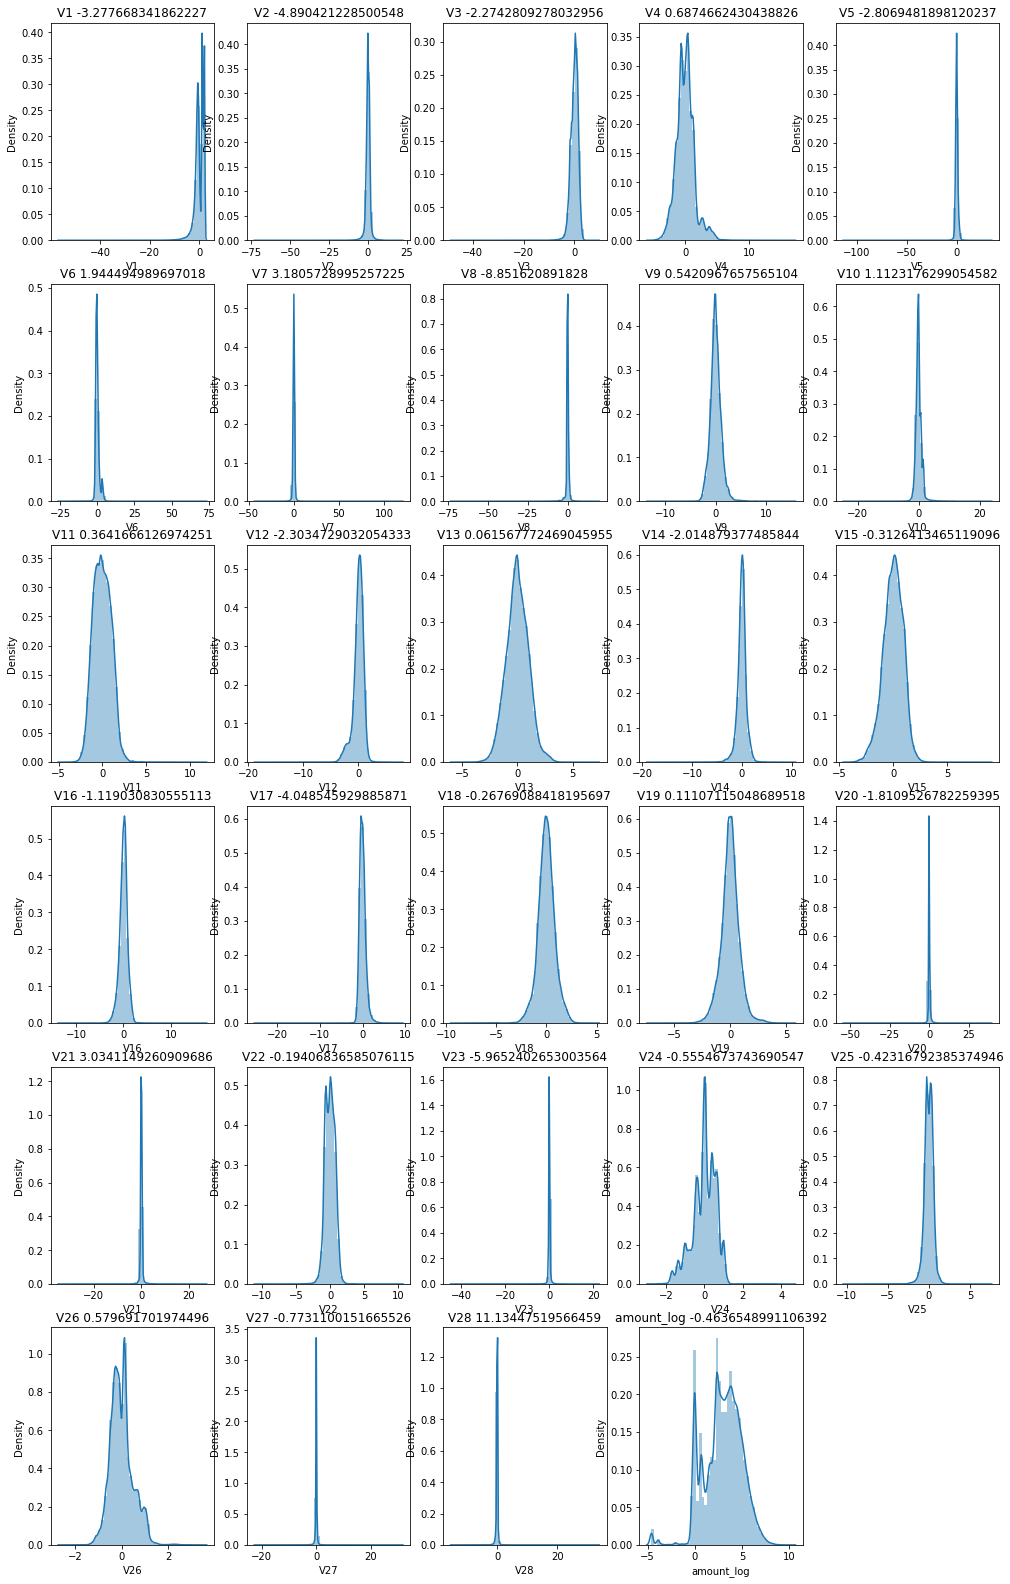

In [23]:
# Plotting the distribution of the variables (skewness) of all the columns
k=0
plt.figure(figsize=(17,28))
for col in cols :    
    k=k+1
    plt.subplot(6, 5,k)    
    sns.distplot(X_train[col])
    plt.title(col+' '+str(X_train[col].skew()))

As we know that the data is heavily imbalanced, where approximately 0.17% transaction are fraud. When evaluating a model, accuracy is an excellent metric to use. Because even if all of the data points output a specific class(1/0), regardless of the prediction, the model will still have a high accuracy of more than 99 percent.
As a result, in order to evaluate the model fairly, we must calculate the ROC-AUC score. The ROC curve is used to assess the model's efficiency by analysing its performance across all categorization threshold.


In [24]:
# instantiating the random undersampler 
rus = RandomUnderSampler()
# resampling X, y
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [25]:
# Befor sampling class distribution
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_rus))

Before sampling class distribution:- Counter({0: 227449, 1: 396})
New class distribution:- Counter({0: 396, 1: 396})


## Logistic Regression

#### Logistic regression with optimal C

I have explicitly performed hyperparameter tuning and found that c = 0.1. The code was small but it increases the page size and in our final report we do always use the tuned parameters so i just mentioned it here.

In [26]:
from sklearn.linear_model import LogisticRegression
logistic_us = LogisticRegression(C=0.1)
logistic_us = logistic_us.fit(X_train_rus, y_train_rus)

#### Prediction on the train set

In [27]:
y_train_pred = logistic_us.predict(X_train_rus)

In [28]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
confusion = metrics.confusion_matrix(y_train_rus, y_train_pred)
print(confusion)

[[391   5]
 [ 32 364]]


In [29]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [30]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_rus, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_train_rus, y_train_pred))

Accuracy:- 0.9532828282828283
Sensitivity:- 0.9191919191919192
Specificity:- 0.9873737373737373
F1-Score:- 0.9516339869281046


In [31]:
print(classification_report(y_train_rus, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       396
           1       0.99      0.92      0.95       396

    accuracy                           0.95       792
   macro avg       0.96      0.95      0.95       792
weighted avg       0.96      0.95      0.95       792



In [32]:
# Predicted probability
y_train_prob = logistic_us.predict_proba(X_train_rus)[:,1]

In [33]:
# roc_auc
auc = metrics.roc_auc_score(y_train_rus, y_train_prob)
auc

0.9875395367819609

In [34]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

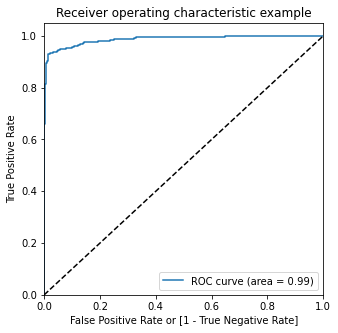

In [36]:
# Plot the ROC curve
draw_roc(y_train_rus, y_train_prob)

#### Prediction on the test set

I have take the whole X_test with 56962 data points for testing but performed testing with 792 data points which was a balanced dataset using the undersampling method.

In [37]:
X_test.shape

(56962, 29)

In [38]:
# Prediction on the test set
y_test_pred = logistic_us.predict(X_test)

In [39]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[55576  1290]
 [   12    84]]


In [40]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9771426565078474
Sensitivity:- 0.875
Specificity:- 0.9773150916188935


In [41]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56866
           1       0.06      0.88      0.11        96

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [42]:
# Predicted probability
y_test_prob = logistic_us.predict_proba(X_test)[:,1]

In [43]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_prob)
auc

0.967442283907197

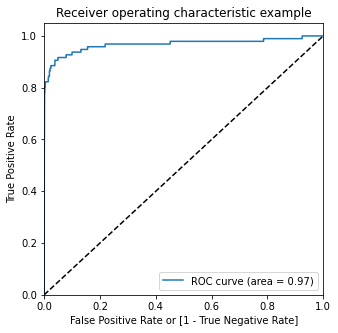

In [44]:
# Plot the ROC curve
draw_roc(y_test, y_test_prob)

## XG Boost Algorithm

In [45]:
from xgboost import XGBClassifier
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
xgb_us = XGBClassifier(params = params)
xgb_us.fit(X_train_rus, y_train_rus)

[23:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

#### Prediction on the train set

In [46]:
# Predictions on the train set
y_train_pred = xgb_us.predict(X_train_rus)

In [47]:
# Confusion matrix
conf = metrics.confusion_matrix(y_train_rus, y_train_rus)
print(conf)

[[396   0]
 [  0 396]]


In [48]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_rus, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 1.0
Sensitivity:- 0.875
Specificity:- 0.9773150916188935


In [49]:
# classification_report
print(classification_report(y_train_rus, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       396
           1       1.00      1.00      1.00       396

    accuracy                           1.00       792
   macro avg       1.00      1.00      1.00       792
weighted avg       1.00      1.00      1.00       792



In [50]:
# Predicted probability
y_train_prob = xgb_us.predict_proba(X_train_rus)[:,1]

In [51]:
# roc_auc
auc = metrics.roc_auc_score(y_train_rus, y_train_prob)
auc

1.0

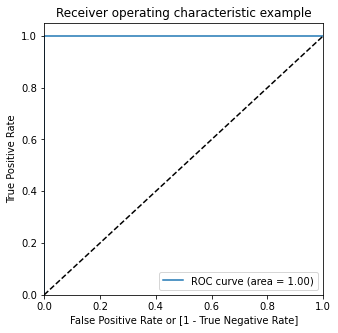

In [52]:
# Plot the ROC curve
draw_roc(y_train_rus, y_train_prob)

#### Prediction on the test set

In [53]:
# Predictions on the test set
y_test_pred = xgb_us.predict(X_test)

In [54]:
# Confusion matrix
conf = metrics.confusion_matrix(y_test, y_test_pred)
print(conf)

[[55022  1844]
 [   11    85]]


In [55]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9674344299708577
Sensitivity:- 0.875
Specificity:- 0.9773150916188935


In [56]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56866
           1       0.04      0.89      0.08        96

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.98     56962



In [57]:
# Predicted probability
y_test_prob = xgb_us.predict_proba(X_test)[:,1]

In [58]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_prob)
auc

0.9790369758144879

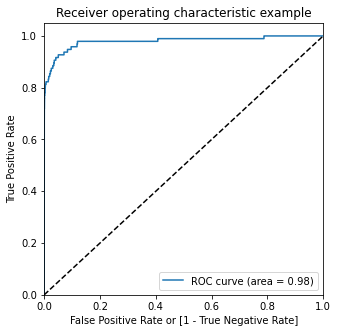

In [59]:
# Plot the ROC curve
draw_roc(y_test, y_test_prob)

### Decision Tree

In [60]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier
# Model with optimal hyperparameters
dt_us = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_us.fit(X_train_rus, y_train_rus)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

#### Prediction on the train set

In [61]:
# Predictions on the train set
y_train_pred = dt_us.predict(X_train_rus)

In [62]:
# Confusion matrix
conf = metrics.confusion_matrix(y_train_rus, y_train_pred)
print(conf)

[[392   4]
 [ 53 343]]


In [63]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_rus, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.928030303030303
Sensitivity:- 0.875
Specificity:- 0.9773150916188935


In [64]:
# classification_report
print(classification_report(y_train_rus, y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       396
           1       0.99      0.87      0.92       396

    accuracy                           0.93       792
   macro avg       0.93      0.93      0.93       792
weighted avg       0.93      0.93      0.93       792



In [65]:
# Predicted probability
y_train_prob = dt_us.predict_proba(X_train_rus)[:,1]

In [66]:
# roc_auc
auc = metrics.roc_auc_score(y_train_rus, y_train_prob)
auc

0.9801168248137945

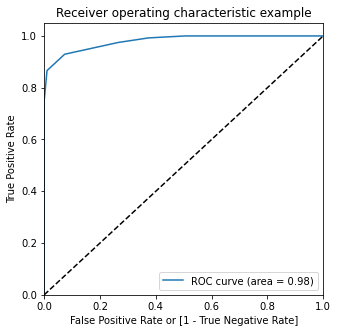

In [67]:
# Plot the ROC curve
draw_roc(y_train_rus, y_train_prob)

#### Prediction on the test set

In [68]:
# Predictions on the test set
y_test_pred = dt_us.predict(X_test)

In [69]:
# Confusion matrix
conf = metrics.confusion_matrix(y_test, y_test_pred)
print(conf)

[[55864  1002]
 [   19    77]]


In [70]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9820757698114533
Sensitivity:- 0.875
Specificity:- 0.9773150916188935


In [71]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56866
           1       0.07      0.80      0.13        96

    accuracy                           0.98     56962
   macro avg       0.54      0.89      0.56     56962
weighted avg       1.00      0.98      0.99     56962



In [72]:
# Predicted probability
y_test_prob = dt_us.predict_proba(X_test)[:,1]

In [73]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_prob)
auc

0.968136532960527

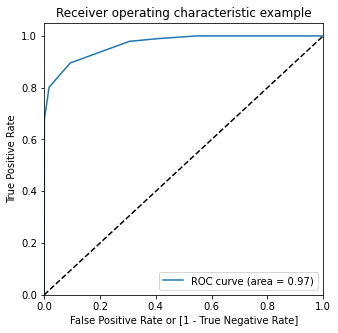

In [74]:
# Plot the ROC curve
draw_roc(y_test, y_test_prob)

## Random forest

In [75]:
# Importing random forest classifier
from sklearn.ensemble import RandomForestClassifier
# model with the best hyperparameters
rfc_us = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=10,
                             n_estimators=200)

In [76]:
# Fit the model
rfc_us.fit(X_train_rus, y_train_rus)

RandomForestClassifier(max_depth=5, max_features=10, min_samples_leaf=50,
                       min_samples_split=50, n_estimators=200)

#### Prediction on the train set

In [77]:
# Predictions on the train set
y_train_pred = rfc_us.predict(X_train_rus)

In [78]:
# Confusion matrix
conf = metrics.confusion_matrix(y_train_rus, y_train_pred)
print(conf)

[[392   4]
 [ 44 352]]


In [79]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_rus, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_train_rus, y_train_pred))

Accuracy:- 0.9393939393939394
Sensitivity:- 0.875
Specificity:- 0.9773150916188935
F1-Score:- 0.9361702127659574


In [80]:
# classification_report
print(classification_report(y_train_rus, y_train_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       396
           1       0.99      0.89      0.94       396

    accuracy                           0.94       792
   macro avg       0.94      0.94      0.94       792
weighted avg       0.94      0.94      0.94       792



In [81]:
# Predicted probability
y_train_prob = rfc_us.predict_proba(X_train_rus)[:,1]

In [82]:
# roc_auc
auc = metrics.roc_auc_score(y_train_rus, y_train_prob)
auc

0.9848548617488011

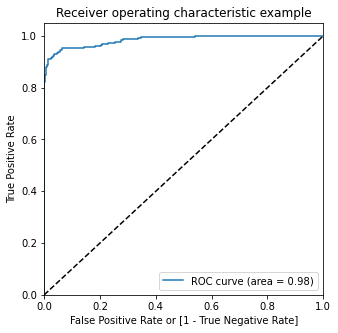

In [83]:
# Plot the ROC curve
draw_roc(y_train_rus, y_train_prob)

#### Prediction on the test set

In [84]:
# Predictions on the test set
y_test_pred = rfc_us.predict(X_test)

In [85]:
# Confusion matrix
conf = metrics.confusion_matrix(y_test, y_test_pred)
print(conf)

[[55887   979]
 [   18    78]]


In [86]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9824971033320459
Sensitivity:- 0.875
Specificity:- 0.9773150916188935


In [87]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56866
           1       0.07      0.81      0.14        96

    accuracy                           0.98     56962
   macro avg       0.54      0.90      0.56     56962
weighted avg       1.00      0.98      0.99     56962



In [88]:
# Predicted probability
y_test_prob = rfc_us.predict_proba(X_test)[:,1]

In [89]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_prob)
auc

0.9734884787629398

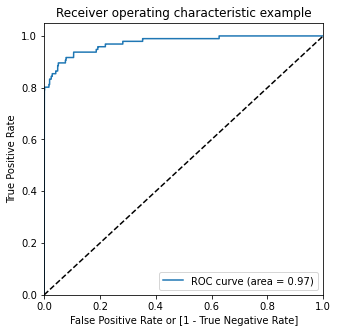

In [90]:
# Plot the ROC curve
draw_roc(y_test, y_test_prob)

Conclusion:
    We have done undersampling and balanced the data and then took the whole train set to train the model

We would like high accuracy for banks with a lower average transaction value since we only want to flag relevant transactions as illegitimate.
We may include the human aspect to each transaction that is tagged as fraudulent by interviewing the client to validate that whether transaction was performed.
When precision is minimal, however, such actions become a burden since the human factor must be addressed. 

If the recall is weak, i.e., it is unable to identify transactions that are categorized as non-fraudulent, this is a problem for banks with higher transaction values.
As a result, if the missing transaction was a high-value fraudulent one, we must factor in the losses.


So, in order to protect banking institutions from large-value fraudulent transactions, we must concentrate on a high recall to identify genuine fraudulent transactions. 